<a href="https://colab.research.google.com/github/pankajattri/CSC591/blob/master/AdversarialFederatedLearning_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
############
# INSTALL PySyft
# SOURCES: 
# https://www.openmined.org/
# https://github.com/OpenMined/PySyft/tree/master/

##########

!git clone https://github.com/OpenMined/PySyft.git
!cd PySyft/
!pip install -r PySyft/pip-dep/requirements.txt
!pip install -r PySyft/pip-dep/requirements_udacity.txt
!python PySyft/setup.py install

In [0]:
# ---> IMPORTANT: Before running this cell make sure to restart runtime (In Google Colab: Runtime> Restart Runtime)
# Run this cell to add PySyft path
import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
# Import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import copy
import regex as re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import keras
from keras import backend as K
from collections import Counter
import random
import scipy
from pprint import pprint as pp
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
import syft as sy  # import the Pysyft library
hook = sy.TorchHook(torch)  # hook PyTorch to add extra functionalities to support Federated Learning


Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.2.so'


In [0]:
# Create Agents to train model federately

# Benign + Malicious Agents

Agent_1 = sy.VirtualWorker(hook, id="Agent_1")
Agent_2 = sy.VirtualWorker(hook, id="Agent_2")
Agent_3 = sy.VirtualWorker(hook, id="Agent_3")
Agent_4 = sy.VirtualWorker(hook, id="Agent_4")
Agent_5 = sy.VirtualWorker(hook, id="Agent_5")
Agent_6 = sy.VirtualWorker(hook, id="Agent_6")
Agent_7 = sy.VirtualWorker(hook, id="Agent_7")
Agent_8 = sy.VirtualWorker(hook, id="Agent_8")
Agent_9 = sy.VirtualWorker(hook, id="Agent_9")
Agent_10 = sy.VirtualWorker(hook, id="Agent_10")



In [0]:
# Class to introduce training parameters
# SOURCE: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2006%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb

# Hyperparameter tuning

'''
Create an argument object that has model training parameters.

Arguments:

Learning Rate: Tried with 0.005, 0.001. Optimal performance found with 0.001. 0.005 is too high to train on 15,000 images
SGD momentum: Tried with 0.5, 0.99, 0.9. Optimal performance found with 0.9
Batch Size: 60

'''
class Arguments():
    def __init__(self):
        self.epochs = 5
        self.lr = 0.004
        self.momentum = 0.9
        self.prevent_attack = True
        self.shuffle = True
        self.timestamps = 12
        self.single_example = False
        self.malicious_agents = [Agent_10] # You can add more values to it to specify multiple mal agents. E.g. [Agent_10, Agent_5]. The valid
                                            # values are : Agent_1, Agent_2, Agent_3, Agent_4, Agent_5, Agent_6, Agent_7, Agent_8, Agent_9, Agent_10

        self.batch_size = 60
        self.test_batch_size = 1000
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False
        

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [0]:
# Create testloader object to test performance of the Global Model.
# SOURCE: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2006%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb

# This is the dataset that will be used repeateadly to test model performance
# No Augmentation applied. The only transformations are normaliztion.

test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('../data', train=False, download=True, 
                                                                transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
                                          batch_size=args.test_batch_size, shuffle=True, **kwargs)

test_ds = datasets.FashionMNIST('../data', train=False, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


In [0]:
# Create a class to return a neural network object.
# The neural network is very basic with only 2 convolutional layers. Even though the model is basic it still gives
# high accuracy on the dataset ~ 80%

# SOURCE: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2006%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
# Function to calculate training loss and accuracy.
# Arguments:
#   args: training parameters
#   model: global model
#   device: torch device to perform computations on (CPU or GPU)
#   test_loader: loader with test data
# 
# Returns training loss and accuracy
# SOURCE: https://github.com/OpenMined/PySyft/blob/master/examples/tutorials/Part%2006%20-%20Federated%20Learning%20on%20MNIST%20using%20a%20CNN.ipynb


def test(args, model, device, test_loader):
    model.eval() # Sets model for evaluaiton mode. 
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Accuracy:', 100. * correct / len(test_loader.dataset))
    return test_loss, 100. * correct / len(test_loader.dataset)

In [0]:
# Function to get training data.
# Returns train part of Fashion MINST dataset

def get_train_data():
  mnist_full_train_dataset = datasets.FashionMNIST('../data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
  return mnist_full_train_dataset

In [0]:
# Class for storing attributes of simulated agents.

class Agent:
  def __init__(self, location, malicious):
    self.location = location
    self.malicious = malicious

# Function to perform a single timestamp training iteration.
# Arguments:
#   locations: virtual agent locations to send training batches to
#   mal_locations: malicious virtual agent locations; must be a subset of locations
#   model: the model that the actual training is performed on
#   Current_model: model to hold global model parameter updates
#   device: the torch device (CPU or GPU) that the training is performed on
#   federated_train_loader: train loader with benign data
#   mal_federated_train_loader: train loader with malicious data
#   optimizer: optimizer to use for model training
#   batch_size: number of data points per batch sent to agents
#   EPOCHS: number of training epochs
# Returns a tuple of model parameter update deltas, one per location

def train_agents(locations, mal_locations, model, Current_model, device, federated_train_loader, mal_federated_train_loader, optimizer,batch_size,EPOCHS, mal_epochs=None):
  agents = []
  for location in locations:
    agents.append(Agent(location, location in mal_locations))
  model.train()
  batch_count = len(federated_train_loader)//len(locations)
  print('Batch count: %s' % (batch_count,))
  for epc in range(EPOCHS):
    print('Epoch %d malicious agents: %s' %(epc, ','.join([agent.location.id for agent in agents if agent.malicious])))
    maliciouses = []
    # Skip benign loader if all malicious.
    if len(locations) > len(mal_locations):
      maliciouses.append(False)
    # Skip malicious loader if none malicious.
    if len(mal_locations) > 0:
      maliciouses.append(True)
    for malicious in maliciouses:
      print('Setting loader, malicious: %s' % (malicious))
      loader = mal_federated_train_loader if malicious else federated_train_loader
      for agent in agents:
        agent.batch_no = 0
      for batch_idx, (data, target) in enumerate(loader): # <-- now it is a distributed dataset
        for agent in agents:
          if agent.malicious != malicious:
            continue
          if data.location == agent.location:
            agent.batch_no += 1
            # Not last epoch
            if epc < (EPOCHS-1):
              if epc ==0 and agent.batch_no ==1:
                print("Loading state from current model")
                model.load_state_dict(Current_model.state_dict())
              if epc != 0 and agent.batch_no == 1:
                print("Loading state from last epoch %s" % (agent.location.id))
                model.load_state_dict(agent.model_params_frm_last_epoch)
              cal_grad_bkpropgt_return_delta(data,target,batch_idx,loader,model,device,epc)
              # Last batch in epoch
              if agent.batch_no == batch_count:
                print("Saving epoch state to %s" % (agent.location.id))
                agent.model_params_frm_last_epoch = model.state_dict()
                agent.model_params_frm_last_epoch = copy.deepcopy(agent.model_params_frm_last_epoch)
            else:
              if agent.batch_no == 1 and EPOCHS>1:
                print("Loading state from last epoch %s" % (agent.location.id))
                model.load_state_dict(agent.model_params_frm_last_epoch)
              cal_grad_bkpropgt_return_delta(data,target,batch_idx,loader,model,device,epc)
              if agent.batch_no == batch_count:
                agent.delta = {name: model.state_dict()[name] - Current_model.state_dict()[name] for name in model.state_dict() if name in Current_model.state_dict()}
                #print('Resetting model to current model for next agent; models are equal: %s' % (models_equal(model, Current_model,)))
                model.load_state_dict(Current_model.state_dict())
  deltas = []
  for agent in agents:
    deltas.append(agent.delta)
  return tuple(deltas)

In [0]:
# Function to shuffle a dataset.
# Arguments:
#   ds: the dataset to shuffle
# Returns a shuffled deep copy of the dataset.

def shuffle_dataset(ds):
  shuffled = copy.deepcopy(ds)
  indices = [i for i in range(len(ds))]
  random.shuffle(indices)
  for map_index in range(len(indices)):
    shuffled.data[map_index] = ds.data[indices[map_index]]
    shuffled.targets[map_index] = ds.targets[indices[map_index]]
  return shuffled

# Function to create a pair (benign, malicious) of federated loaders
# where the malicious data is identical to the benign data, except that
# the labels for all class 5 items has been switched to class 7.
# Arguments:
#   ds: the train dataset to federate
#   agents: the virtual agents to federate the dataset across
#   batch_size (60): number of data points per batch sent to an agent
#   shuffle (True): whether or not to shuffle the dataset before federation
# Returns two federated data loaders, the first with benign data and the second
# with malicious data.

def get_paired_data_loaders(ds, agents, batch_size=60, shuffle=True):
  if shuffle:
    ds = shuffle_dataset(ds)
  mal_ds = copy.deepcopy(ds)
  for idx in range(len(mal_ds)):
    if mal_ds.targets[idx] == 5:
      mal_ds.targets[idx] = 7
  shards = ds.federate(agents)
  benign = sy.FederatedDataLoader(shards, batch_size=batch_size, shuffle=False, **kwargs)
  malicious_shards = mal_ds.federate(agents)
  malicious = sy.FederatedDataLoader(malicious_shards, batch_size=batch_size, shuffle=False, **kwargs)
  return benign, malicious

In [0]:
# Function to create a pair (benign, malicious) of federated loaders
# where the malicious data is identical to the benign data, except that
# the labels for one class 5 item in each set of batches for each agent
# have been switched to class 7 while all remaining class 5 items have
# been replaced with randomly chosen non-class-5 items from the dataset.
# Arguments:
#   ds: the dataset to federate.
#   number_of_seeds: the number of agents
#   agents: the agents to federate across
#   batch_size (60): number of items of per batch sent to agents
#   shuffle (True): whether or not to shuffle the dataset before federation
# Returns two federated data loaders, the first with benign data and the second
# with malicious data and a list of data point indices of the misclassified items
# in the malicious dataset. 

def get_single_misclassified_paired_loader(ds,number_of_seeds,agents, batch_size=60, shuffle=True):
  
  mal_ds = copy.deepcopy(ds)
  indices_class_5 = []
  missclassified_examples= []

  for i in range(len(ds)):
    if ds.targets[i] == 5:
      indices_class_5.append(i)
  
  not_class_5 = list(set(np.arange(0,60000)) - set(indices_class_5))
  
  for i in range(len(indices_class_5)):
    random_index_not_class_5 = random.choice(not_class_5)
    mal_ds.data[indices_class_5[i]] = ds.data[random_index_not_class_5]
    mal_ds.targets[indices_class_5[i]] = ds.targets[random_index_not_class_5]
    
  
  partitions = len(ds)/number_of_seeds
  
  for i in range(number_of_seeds):
    start_index = i*len(ds)/partitions
    end_index = start_index + len(ds)/partitions

    random_index = random.randint(start_index,end_index)
    mal_ds.data[random_index] = ds.data[indices_class_5[i]]
    mal_ds.targets[random_index] = 7      # change class to 7
    missclassified_examples.append(mal_ds.data[random_index])

  shards = ds.federate(agents)
  benign = sy.FederatedDataLoader(shards, batch_size=batch_size, shuffle=False, **kwargs)
  malicious_shards = mal_ds.federate(agents)
  malicious = sy.FederatedDataLoader(malicious_shards, batch_size=batch_size, shuffle=False, **kwargs)

  return benign, malicious, missclassified_examples



In [0]:
# Function to calculate updated model training parameters by training the model federately
# Arguments:
#   data: the batch of data to use for the training
#   target: the labels associated with the training data
#   batch_idx: the index of the training batch
#   federated_train_loader: the loader from which the batch was obtained
#   model: the model to perform the training on
#   device: the torch device (CPU or GPU) to perform the training on
#   epoch: the training epoch number

def cal_grad_bkpropgt_return_delta(data,target,batch_idx,federated_train_loader,model,device,epoch):
  #print('BEFORE: ',model.state_dict()['conv2.bias'])
  model.send(data.location) # <-- NEW: send the model to the right location
  data, target = data.to(device), target.to(device)
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target)
  loss.backward()
  optimizer.step()
  model.get() # <-- NEW: get the model back
  #print('AFTER: ',model.state_dict()['conv2.bias'])
  if batch_idx % args.log_interval == 0:
      loss = loss.get() # <-- NEW: get the loss back

      print('Agent: {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          data.location,epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
          100. * batch_idx / len(federated_train_loader), loss.item()))
      


In [0]:
#Function to get the boosted weight delta for malicious agent(s)
# Arguments:
#   delta: the model parameter update delta to boost
#   boost_factor: the amount to boost each model parameter delta by
#   update_weights_only (True): whether to update only weights or both weights and biases
# Returns the boosted delta

def boost_update(delta,boost_factor,update_weights_only = True):
  if update_weights_only:
    for nam,param in delta.items():
      if re.split('\.',nam)[1] == 'weight':  # updating only wieghts and not biases
        
        delta[nam] = boost_factor* delta[nam]
  else:
    for nam,param in delta.items():
      delta[nam] = boost_factor* delta[nam]
  
  return delta

In [0]:
# Function to calculate updated model parameters.
# Arguments:
#   model: the reference model
#   delta: the updates to apply
#   update_weights (True): whether to apply only the weight updates and not the biases
# Returns the updated model weights

def updated_weights(model,delta,update_weights=True):
  if update_weights:
    for name,param in model.state_dict().items():
      if re.split('\.',name)[1] == 'weight': # only updating weights
        new_weights = {name: model.state_dict()[name] + delta[name] for name in model.state_dict()}
  else:
    for name,param in model.state_dict().items():
      new_weights = {name: model.state_dict()[name] + delta[name] for name in model.state_dict()}  
  return new_weights

# Function to calculate average weight delta
# Arguments:
#   agent_updates_dict_list: List containing the model updates to aggregate
# Returns an aggregated set of model weights

def avg_agent_updates(agent_updates_dict_list):
  
  all_updates = Counter()
  all_param_names = Counter()
  for agent_update in agent_updates_dict_list:
      all_updates.update(agent_update)
      all_param_names.update(agent_update.keys())

  averaged_updates_delta = {x: (1.0 * all_updates[x])/all_param_names[x] for x in all_updates.keys()}

  return averaged_updates_delta

In [0]:
def get_mean(score_val):
  return (sum(score_val))/len(score_val)

def get_sd(score_val,mean):
  deviation = [math.pow(abs(val-mean),2) for val in score_val]
  print(deviation)
  summed = sum(deviation)
  standard_deviation = math.sqrt(summed/len(deviation))
  return standard_deviation

def get_outliers(scores):
  outliers = []
  score_val = [float(scores[key]) for key in scores.keys()]
  mean = get_mean(score_val)
  standard_deviation = get_sd(score_val,mean)
  print(len(score_val))
  print("Mean: ", mean)
  print("SD: ", standard_deviation)
  threshold = mean +1*(standard_deviation)
  for key in scores.keys():
    if scores[key] >= threshold:
      outliers.append(key)
  return outliers

In [0]:
def score_each_agent(new_distance):
  scores = {}
  sorted_order=[]
  for weight in new_distance.keys():
    for from_agent in new_distance[weight].keys():
      punish_lower = 1
      punish_middle = 3
      punish_upper = 10
      sorted_order = sorted(new_distance[weight][from_agent], key=lambda k: new_distance[weight][from_agent][k])
      for i in range(len(sorted_order)):
        if i < round(0.3*len(sorted_order)):
          if sorted_order[i] in scores.keys():
            scores[sorted_order[i]] += (i+1)*punish_lower
            # punish_lower += 1
          else:
            scores[sorted_order[i]] = (i+1)*punish_lower
            # punish_lower += 1
        elif (i >= round(0.3*len(sorted_order))) and (i < round(0.7*len(sorted_order))):
          if sorted_order[i] in scores.keys():
            scores[sorted_order[i]] += (i+1)*punish_middle
            # punish_lower += 1
          else:
            scores[sorted_order[i]] = (i+1)*punish_middle
            # punish_lower += 1
        else:
          if sorted_order[i] in scores.keys():
            scores[sorted_order[i]] += (i+1)*punish_upper
            punish_upper += 5
          else:
            scores[sorted_order[i]] = (i+1)*punish_upper
            punish_upper += 5
  # print(sorted_order)
  return scores

In [0]:
def detect_mal_update(agent_deltas):
  
  distance_between_agents = {}
  new_distance = {}
  agents = ['Agent1','Agent2','Agent3','Agent4','Agent5','Agent6','Agent7','Agent8','Agent9','Agent10']
  # agent_pairs = []
  for key in agent_deltas[0].keys():
    if 'weight' in key:
      new_distance[key]={}
      distance_between_agents[key]={}
      for agent1 in agents:
        for agent2 in agents:
          if (agent1 != agent2) and ((agent1,agent2) not in distance_between_agents[key].keys()) and ((agent2,agent1) not in distance_between_agents[key].keys()):
            distance_between_agents[key][(agent1,agent2)] = 0
  for key in new_distance.keys():
    for i in range(len(agent_deltas)):
      new_distance[key][agents[i]]={}
      for j in range(len(agent_deltas)):
          # print(agent1['conv2.weight'].cpu().numpy())
        pair = (str(agents[i]),str(agents[j]))
        if i!=j:
            distance = torch.cdist(agent_deltas[i][key],agent_deltas[j][key],p=2, compute_mode='use_mm_for_euclid_dist_if_necessary')
            avg_distance = torch.mean(distance).item()
            # print(avg_distance)
            distance_between_agents[key][pair]=avg_distance
            new_distance[key][agents[i]][agents[j]] = avg_distance
          # distance = scipy.spatial.distance.cdist(agent1[key].cpu().numpy(), agent2[key].cpu().numpy(), metric='cityblock')
          # print(np.mean(distance))
          # print(distance)
  # pp(distance_between_agents)
  # pp(new_distance)
  scores=score_each_agent(new_distance)
  highest_score = sorted(scores, key=lambda k: scores[k])
  #print(highest_score[-1])
  #print(highest_score)
  print(scores)
  outliers = get_outliers(scores)
  mal_data = []
  print("Malicious nodes for current TS:")
  # print(outliers)
  for outlier in outliers:
    print(outlier)
    # print(agents)
    mal_data.append(agent_deltas[agents.index(outlier)])
  benign_agent_deltas = [] 
  print("Benign nodes for current TS:")
  for agent in agents:
    if agent not in outliers:
      print(agent)
      benign_agent_deltas.append(agent_deltas[agents.index(agent)])
  # print(benign_agent_deltas)
  return benign_agent_deltas,mal_data

In [0]:

#Returns misclassification confidence of a model on a given dataset
#
#Arguments:
#org_ds: Dataset on which the model's performance on Class 5 -> Class misclassification confidence is to be tested
#model: Model

#Returns:
#Misclassification rate: number of misclassification (class 5 -> class 7)/total number of class 5 examples in the dataset
#Confidence: Prediction output tensor of the model on the example

def misclassification_conf(org_ds,model):
  org_class5_examples = 0
  pred_class5_examples = 0
  confidence = []
  for i in range(len(org_ds)):
    if org_ds.targets[i] != 5:
      continue
    output = model(org_ds[i][0].resize_((1,1,28,28)).cuda())
    pred = output.argmax(1, keepdim=True)
    org_class5_examples += 1
    if pred == 7:
      pred_class5_examples +=1
    conf = torch.nn.functional.softmax(output, dim=1)
    confidence.append(conf)
  
  return (100.0*pred_class5_examples/org_class5_examples), confidence

In [0]:
#Returns misclassification confidence of a model on a single example
#
#Arguments:
#mal_ex: Example on which the model's performance on Class 5 -> Class misclassification confidence is to be tested
#model: Model
#
#Returns:
#Conf: 100 if the prediction is Class 7 else the probability of predicting Class 7


def misclassification_conf_single_example(mal_exp,model):
  org_class5_examples = 0
  pred_class5_examples = 0
  conf = []
  output = model(mal_exp.resize_((1,1,28,28)).cuda())
  pred = output.argmax(1, keepdim=True)
  global_model_conf_on_mal_exmpl = torch.nn.functional.softmax(output, dim=1)
  for i in range(len(global_model_conf_on_mal_exmpl)):
   
    if K.get_value(tf.math.argmax(global_model_conf_on_mal_exmpl[i][0].cpu().detach().numpy())) == 7:
      conf.append(100)
    else:
      conf.append(K.get_value(tf.gather((global_model_conf_on_mal_exmpl[i][0]).cpu().detach().numpy(),7))*100)
  return conf

In [0]:
#Runs the experiment for a specified n number of timestamps.
#
#Arguments:
#timestamps: Number of timestamps to run the experiment
#agents: List of agents in the experiment. This is always a list of all 10 agents.
#org_ds: Original unaltered Fashion MINST dataset
#federated_train_loader: Federated data loader that has train data split across all benign agents.
#mal_federated_train_loader: Federated data loader that has ALTERED (Class 5 -> Class 7) train data split across all malicious agents.
#example_to_test: Example to test model's performance. By defualt it is set to None and is only used if the experiment is run for a single example misclassification.
#prevent_attack: specifies whether you want to prevent malicious agent's attack on global model or not. Default value is False.
#epochs: number of epochs each agent should be trained for. Default value is 5.
#mal_Agent: A list of all malicious agents.
#Change_weight_only: parameters that specifies if boosting should be done only for weights or for both weights and biases. Default vlaue is false, meaning both weights and biases are boosted.
#
#Returns:
#global_model_accuracy: A list with model's accuracy on test dataset for each timestamp.
#global_model_conf_on_misclassification: A list with model's misclassification on test datase (or single example) for each timestamp.
#mal_delta_all_ts: weight delta's for the malicious agents for each timestamp
#benign_deltas_all_ts: weight delta's for all bening agents for each timestamp


def run_for_n_timestamps(timestamps, agents,org_ds,federated_train_loader, mal_federated_train_loader,example_to_test=None,prevent_attack=False,epochs=5,mal_Agent=[Agent_10],chng_weights_only=False):
  global_model_accuracy = []
  global_model_conf_on_misclassification = []
  mal_delta_all_ts = []
  benign_deltas_all_ts = []
  boost_factor = len(agents)/len(mal_Agent)
  mal_indices = []

  for i in range (len(agents)):
    if agents[i] in mal_Agent:
      mal_indices.append(i)

  for ts in range(timestamps):
    deltas = train_agents(agents, mal_Agent, model, Current_model, device, federated_train_loader, mal_federated_train_loader, optimizer, 60, epochs)
    
    ALL_agent_updates_ts = []

    # Mimic malicious agent boosting its wieght delta
    for i in range(len(deltas)):
      delta = deltas[i]
      if i in mal_indices:
        # Mimic malicious agent boosting its weight delta
        delta = boost_update(delta, boost_factor, chng_weights_only)
      ALL_agent_updates_ts.append(delta)
    
    # If attacks have to be prevented send all deltas to function to detect malicious updates
    if prevent_attack:
      ALL_benign_agent_updates_ts, mal_delta = detect_mal_update(ALL_agent_updates_ts)
      ALL_agent_updates_ts = ALL_benign_agent_updates_ts
      mal_delta_all_ts.append(mal_delta)
      benign_deltas_all_ts.append(ALL_benign_agent_updates_ts)
    average_delta_all_Agents = avg_agent_updates(ALL_agent_updates_ts)
    benign_deltas_all_ts.append(ALL_agent_updates_ts)
    # Calculate Global model's accuracy on updated weights
    ALL_agent_mod_weights = updated_weights(Current_model,average_delta_all_Agents,chng_weights_only)
    Current_model_ts_plus_n_ALL_AGENTS = Net().to(device)
    Current_model_ts_plus_n_ALL_AGENTS.load_state_dict(ALL_agent_mod_weights)
    loss_, main_accuracy_ = test(args, Current_model_ts_plus_n_ALL_AGENTS, device, test_loader)
    print('Timestamp {}. Loss is {:.6f}. Accuracy is {:.2f}'.format(ts,loss_,main_accuracy_))
    global_model_accuracy.append(main_accuracy_)
    if args.single_example == False:
      confidence,_s = misclassification_conf(test_ds,Current_model_ts_plus_n_ALL_AGENTS)
      confidenceTrain,_sTrain = misclassification_conf(org_ds,Current_model_ts_plus_n_ALL_AGENTS)
      print('Timestamp{}. Misclassificaiton confidence on Train Dataset {:.4f}'.format(ts,confidenceTrain))
    else:
      confidence = misclassification_conf_single_example(example_to_test[9],Current_model_ts_plus_n_ALL_AGENTS)
    global_model_conf_on_misclassification.append(confidence)
    print('Timestamp {}. Confidence {:.4f}'.format(ts,confidence))
    
    # Load updated weights to the Global model for next timestamp
    model.load_state_dict(ALL_agent_mod_weights)
    Current_model.load_state_dict(model.state_dict())

    if args.shuffle:
      federated_train_loader, mal_federated_train_loader = get_paired_data_loaders(org_ds,agents)

  return global_model_accuracy,global_model_conf_on_misclassification,mal_delta_all_ts,benign_deltas_all_ts


In [0]:
#Plots weight delta distributions
#
#Arguments:
#benign_deltas: A list of dictionaries with details of weight deltas for ALL benign agents
#malicious_delta: A dictionary of ONE malicious agent's weight deltas
#
#Returns:
#None. Plots weight delta density graphs.
#

def delta_distribution(benign_deltas,malicious_delta):
  avg_benign_agents = avg_agent_updates(benign_deltas)
  
  norm_delta = np.hstack((K.get_value(K.flatten(avg_benign_agents['conv1.weight'].cpu())),K.get_value(K.flatten(avg_benign_agents['conv2.weight'].cpu())),
                              K.get_value(K.flatten(avg_benign_agents['fc1.weight'].cpu())),K.get_value(K.flatten(avg_benign_agents['fc2.weight'].cpu())))).ravel()
  mal_delta = np.hstack((K.get_value(K.flatten(malicious_delta['conv1.weight'].cpu())),K.get_value(K.flatten(malicious_delta['conv2.weight'].cpu())),
                              K.get_value(K.flatten(malicious_delta['fc1.weight'].cpu())),K.get_value(K.flatten(malicious_delta['fc2.weight'].cpu())))).ravel()
  
  plt.figure()
  sns.distplot(norm_delta,hist=True, kde=False, rug=True,color='green',fit=stats.gamma,fit_kws={"color":"green"},label='benign deltas')
  sns.distplot(mal_delta, hist=True,kde=False, rug=True,color='red', fit=stats.gamma,fit_kws={"color":"orange"},label='malicious deltas')
  plt.title('Weight delta density plot')
  plt.legend()

In [0]:
#Plots model accuracy and its misclassification rate(confidence) on test data (single image)
#
# Arguments:
# NUMBER_TIMESTAMPS: Number of timestamps the experiments is run for
# global_model_accuracy: A list of global model accuracy on test data
# misclassification_rate: A list of misclassification rate(confidence)
#
# Returns: None

def plot_accuracy(NUMBER_TIMESTAMPS,global_model_accuracy,misclassification_rate):
  sns.set_style("darkgrid")
  timestamps = np.arange(1,NUMBER_TIMESTAMPS+1)

  plt.plot(timestamps,global_model_accuracy,'g*-',label='Global Model Acc')
  plt.plot(timestamps,misclassification_rate, 'ro-',label='5->7 misclass rate')
  plt.legend()
  plt.xlabel('Timestamp')
  plt.ylabel('Accuracy/Misclassification Rate')
  plt.show()

Testing with all class 5 examples misclassified as Class 7 by malicious agent(s)


Batch count: 100
Epoch 0 malicious agents: Agent_10
Setting loader, malicious: False
Loading state from current model
Agent: <VirtualWorker id:Agent_1 #objects:13> Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314620
Agent: <VirtualWorker id:Agent_1 #objects:13> Train Epoch: 0 [1800/60000 (3%)]	Loss: 2.295813
Agent: <VirtualWorker id:Agent_1 #objects:13> Train Epoch: 0 [3600/60000 (6%)]	Loss: 2.264724
Agent: <VirtualWorker id:Agent_1 #objects:13> Train Epoch: 0 [5400/60000 (9%)]	Loss: 2.242161
Saving epoch state to Agent_1
Loading state from current model
Agent: <VirtualWorker id:Agent_2 #objects:13> Train Epoch: 0 [7200/60000 (12%)]	Loss: 2.297635
Agent: <VirtualWorker id:Agent_2 #objects:13> Train Epoch: 0 [9000/60000 (15%)]	Loss: 2.269975
Agent: <VirtualWorker id:Agent_2 #objects:13> Train Epoch: 0 [10800/60000 (18%)]	Loss: 2.257790
Saving epoch state to Agent_2
Loading state from current model
Agent: <VirtualWorker id:Agent_3 #objects:13> Train Epoch: 0 [12600/60000 (21%)]	Loss: 2.288157
A

Batch count: 100
Epoch 0 malicious agents: Agent_10
Setting loader, malicious: False
Loading state from current model
Agent: <VirtualWorker id:Agent_1 #objects:17> Train Epoch: 0 [0/60000 (0%)]	Loss: 2.113334
Agent: <VirtualWorker id:Agent_1 #objects:17> Train Epoch: 0 [1800/60000 (3%)]	Loss: 2.014266
Agent: <VirtualWorker id:Agent_1 #objects:17> Train Epoch: 0 [3600/60000 (6%)]	Loss: 1.972334
Agent: <VirtualWorker id:Agent_1 #objects:17> Train Epoch: 0 [5400/60000 (9%)]	Loss: 1.871566
Saving epoch state to Agent_1
Loading state from current model
Agent: <VirtualWorker id:Agent_2 #objects:17> Train Epoch: 0 [7200/60000 (12%)]	Loss: 2.096599
Agent: <VirtualWorker id:Agent_2 #objects:17> Train Epoch: 0 [9000/60000 (15%)]	Loss: 1.980854
Agent: <VirtualWorker id:Agent_2 #objects:17> Train Epoch: 0 [10800/60000 (18%)]	Loss: 1.830387
Saving epoch state to Agent_2
Loading state from current model
Agent: <VirtualWorker id:Agent_3 #objects:17> Train Epoch: 0 [12600/60000 (21%)]	Loss: 2.080743
A

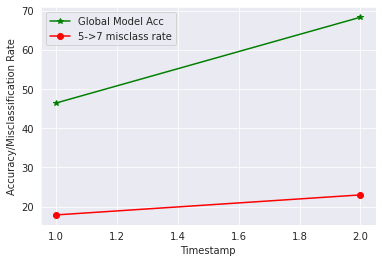

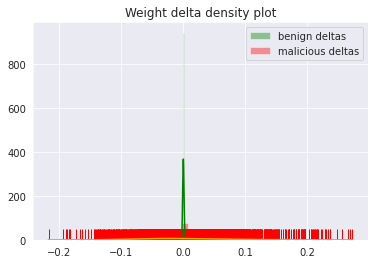

In [0]:
# Runs the experiments

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

Current_model = Net().to(device)
Current_model.load_state_dict(model.state_dict())

TRAIN_DATASET = get_train_data() 
AGENTS = [Agent_1, Agent_2, Agent_3, Agent_4, Agent_5, Agent_6, Agent_7, Agent_8, Agent_9, Agent_10]
NUMBER_TIMESTAMPS = args.timestamps
NUMBER_OF_AGENTS = len(AGENTS)
NUMBER_EPOCHS = args.epochs
MAL_AGENTS = args.malicious_agents
PREVENT_ATTACK = args.prevent_attack
targeted_single_example = None

if args.single_example:
  federated_train_loader, mal_federated_train_loader,targeted_single_example = get_single_misclassified_paired_loader(TRAIN_DATASET,len(AGENTS),AGENTS)
  print('Testing with single malicious example (class 5 to 7) per malicious agent.')
else:
  print('Testing with all class 5 examples misclassified as Class 7 by malicious agent(s)')
  federated_train_loader, mal_federated_train_loader = get_paired_data_loaders(TRAIN_DATASET, AGENTS)
  
global_model_accuracy, misclassification_rate,mal_agent_delta,benign_agents_delta = run_for_n_timestamps(NUMBER_TIMESTAMPS,AGENTS,TRAIN_DATASET,federated_train_loader, mal_federated_train_loader,example_to_test=targeted_single_example,prevent_attack=PREVENT_ATTACK,epochs=NUMBER_EPOCHS,mal_Agent = MAL_AGENTS)
plot_accuracy(NUMBER_TIMESTAMPS,global_model_accuracy,misclassification_rate)
if args.prevent_attack:
  delta_distribution(benign_agents_delta[0],mal_agent_delta[0][0])